# Recopilar datos. 
Una vez scrapeados los datos de REMAX, los guardamos en un excel, y procedemos a cargarlos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
import folium as folium
import sys
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
# Conectamos con nuestro Google Drive
drive.mount('/content/drive')
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/FinMaster/"
# agregamos a las paths del sistema la del colab
sys.path.append(BASE_FOLDER)

Mounted at /content/drive


In [ ]:

class PrepararDatos():
  def __init__(self, BASE_FOLDER):
    datos = os.path.join(BASE_FOLDER, "o_datos1.dat")
    df = pd.read_csv(datos, sep=';', index_col=0, engine='python')
    df.drop(columns=['_id', 'price', 'titulo', 'tipoTran', 'estadoTran', 'NoAmb', 'NoBan', 'NoDorm'], axis=1, inplace=True) #, 'NoMetros'
    df['Terreno'] = np.where(((df['Terreno'].isnull()) & (df['tipoInv'] == 'Departamento')), 0,  df['Terreno'])
    df['estado'] = np.where(((df['estado'].isnull()) & (df['tipoInv'] == 'Terreno')), 'Usada',  df['estado'])
    df['Ano Construcción'] = np.where((df['tipoInv'] == 'Terreno') & (df['Ano Construcción']<=0 | df['Ano Construcción'].isnull()), 0,  df['Ano Construcción'])
    df['Terreno'] = pd.to_numeric(df['Terreno'], errors='coerce')
    df['NoMetros'] = pd.to_numeric(df['NoMetros'], errors='coerce')
    # encontrar el dato con el valor de precio muy ato
    df['borrar'] = np.where(df['precio'] > 100000000 , 5,  0)
    df[df['borrar'] >= 3]
    df.drop(df[df['borrar']> 2].index, inplace = True)
    df['borrar'] = np.where(df['Total M²'] > 1000000000 , 5,  0)
    df[df['borrar'] >= 3]
    df.drop(df[df['borrar']> 2].index, inplace = True)
    df['estado'] = np.where(df['estado'] == 'RESERVADA' , 'Usada',df['estado'])
    df['estado'] = np.where(df['estado'] == 'VENDIDA' , 'Usada',df['estado'])
    df['estado'] = np.where(df['estado'] == 'PROBABLE' , 'Usada',df['estado'])
    df['tipoInv'] = np.where(df['tipoInv'] == 'Inversión' , 'Casa',df['tipoInv'])
    df['tipoInv'] = np.where(df['tipoInv'] == 'Quinta' , 'Casa',df['tipoInv'])
    df.drop(df[df['tipoInv']=='Terreno'].index, inplace = True)
    df.drop(df[(df['lat']==0) | (df['lng']==0)].index, inplace = True)
    df.drop(df[df['precio']<=15000.].index, inplace = True)
    print('Forma de los datos: ' + str(df.shape))
    print('Tipos de datos: ' + str(df.dtypes))
    df['borrar'] = 0
    df['borrar'] = np.where(df['estado'].isnull() , df['borrar'] +1 , df['borrar'])
    df['borrar'] = np.where(df['Area Construcción'].isnull() , df['borrar'] +1 , df['borrar'])
    df['borrar'] = np.where(df['Terreno'].isnull() , df['borrar'] +1 , df['borrar'])
    df['borrar'] = np.where(df['Total M²'].isnull() , df['borrar'] +1 , df['borrar'])
    df[df['borrar']> 2].groupby(by='tipoInv').count()
    df.drop(df[df['borrar']> 2].index, inplace = True)
    self.df = df
    return

  def SeparaAtributos(self, df):
    categoricos= pd.DataFrame(df.iloc[:,0:2])
    continuos0= pd.DataFrame(df.iloc[:,8:10])
    continuos1= pd.DataFrame(df.iloc[:,36:36])
    continuos2= pd.DataFrame(df.iloc[:,39:43])
    continuos3= pd.DataFrame(df.iloc[:,50:52])
    continuos4= pd.DataFrame(df.iloc[:,58:59])
    continuos5= pd.DataFrame(df.iloc[:,61:62])
    ubicacion= pd.DataFrame(df.iloc[:,59:61])
    categoricos1= pd.DataFrame(df.iloc[:,62:63])
    continuos = pd.concat([continuos0, continuos1], axis=1)
    continuos = pd.concat([continuos, continuos2], axis=1)
    continuos = pd.concat([continuos, continuos3], axis=1)
    continuos = pd.concat([continuos, continuos4], axis=1)
    continuos = pd.concat([continuos, continuos5], axis=1)
    categoricos = pd.concat([categoricos, categoricos1], axis=1)
    categoricos.columns = ['Estado', 'Dirección', 'Tipo Propiedad']
    continuos.columns = ['Año de Construcción', 'Area de Construcción',  'No Ambientes', 'No Baños', 'No Dormitorios', 'No Estacionamientos', 'Terreno mts', 'Total M²', 'No Metros', 'Precio']

    bin1= pd.DataFrame(df.iloc[:,2:8])
    bin1.index = range(bin1.shape[0])
    bin2= pd.DataFrame(df.iloc[:,10:36])
    bin2.index = range(bin2.shape[0])
    bin3= pd.DataFrame(df.iloc[:,37:39])
    bin3.index = range(bin3.shape[0])
    bin4= pd.DataFrame(df.iloc[:,43:50])
    bin4.index = range(bin4.shape[0])
    bin5= pd.DataFrame(df.iloc[:,52:58])
    bin5.index = range(bin5.shape[0])
    binarios = pd.concat([bin1, bin2], axis=1)
    binarios = pd.concat([binarios, bin3], axis=1)
    binarios = pd.concat([binarios, bin4], axis=1)
    binarios = pd.concat([binarios, bin5], axis=1)

    return continuos, categoricos, ubicacion, binarios

  def GraficarDiscretos(self, df):
    dato= pd.DataFrame(df.iloc[:,2:8].sum(), columns=['True'])
    dato['False'] = df.count()- dato['True']
    dato1= pd.DataFrame(df.iloc[:,10:36].sum(), columns=['True'])
    dato1['False'] = df.count()- dato1['True']
    dato2= pd.DataFrame(df.iloc[:,37:39].sum(), columns=['True'])
    dato2['False'] = df.count()- dato2['True']
    dato3= pd.DataFrame(df.iloc[:,43:50].sum(), columns=['True'])
    dato3['False'] = df.count()- dato3['True']
    dato4= pd.DataFrame(df.iloc[:,52:58].sum(), columns=['True'])
    dato4['False'] = df.count()- dato4['True']
    total = dato.append(dato1)
    total = total.append(dato2)
    total = total.append(dato3)
    total = total.append(dato4)
    width = 0.55  
    fig, ax = plt.subplots( figsize=(12,3))
    ax.bar(total.index, total['True'], width,  label='Si tiene')
    ax.bar(total.index, total['False'], width, bottom=total['True'], label='No tiene')
    ax.set_ylabel('No de Propiedades')
    ax.set_title('Características de las Propiedades Inmobiliarias')
    ax.set_xticklabels(total.index, rotation=90)
    ax.legend()
    plt.show()
    return

  def EntrenarImputadorContinuo(self, df):
    self.imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    self.imp.fit(df)

  def ImputarContinuos(self, df):
    # Limpieza de datos: imputación valores ausentes (aplicación).
    df_cont_imp = pd.DataFrame(self.imp.transform(df))
    df_cont_imp.columns = ['Año de Construcción', 'Area de Construcción',  'No Ambientes', 'No Baños', 'No Dormitorios', 'No Estacionamientos', 'Terreno mts', 'Total M²', 'No Metros', 'Precio']
    estadisticas = pd.DataFrame(df_cont_imp.describe())
    display(estadisticas.transpose())
    return df_cont_imp
 
  def EntrenarImputadorDiscreto(self, df):
    self.impCat = SimpleImputer(strategy="most_frequent")
    self.impCat.fit(df)

  def ImputarDiscretos(self, df):   
    # Limpieza de datos: imputación valores ausentes (aplicación).
    df_cat_imp = pd.DataFrame(self.impCat.transform(df),  index=[df.index])
    df_cat_imp.columns = ['Estado', 'Dirección', 'Tipo Propiedad']    
    display(df_cat_imp.describe())
    return df_cat_imp

  def OutliersUbicacionEntrenar(self, df):
    # Limpieza de datos: detección de outliers.
    # obtenemos el conjunto de datos con latitud y longitud de ecuador, y los que no tienen datos de ecuador.
    self.outlier_method_u = EllipticEnvelope().fit(df)

  def OutliersUbicacion(self, df, continuo, categorico, binario):
    scores_pred = self.outlier_method_u.decision_function(df)
    Q1 = stats.scoreatpercentile(scores_pred, 10)
    Q3 = stats.scoreatpercentile(scores_pred, 90)
    RIC = Q3 - Q1
    li = Q1 - 1.5*RIC
    ls = Q3 + 1.5*RIC
    # Estimación de outliers
    pos_i = np.where(scores_pred<li)
    pos_s = np.where(scores_pred>ls)
    # Matriz de outliers
    mask_outliers = np.ones(np.shape(scores_pred))
    mask_outliers[pos_i] = 0
    mask_outliers[pos_s] = 0
    valores, ocurrencias = np.unique(mask_outliers==1, return_counts=True)
    df_outliers= df[mask_outliers==0]
    df_infgeo= df[mask_outliers==1]    
    #self.df = self.df[mask_outliers==1]
    df_outliers_des= categorico[mask_outliers==0]
    categoricos_out= categorico[mask_outliers==1]
    binario_out= binario[mask_outliers==1]
    df_validos = continuo[mask_outliers==1]
    print('validos completo : '+ str(df_validos.shape))
    print('outliers : '+ str(df_outliers.shape))
    center_lat = -0.3163390
    center_lon = -78.46403
    self.locationmap = folium.Map(location=[ center_lat , center_lon ], zoom_start=2, width=800, height=600 )
    longitud  = len( df_outliers)

    for i in range ( longitud ):
        lng = float(df_outliers.iloc[i]['lng'])
        lat = float(df_outliers.iloc[i]['lat'])
        description = df_outliers_des.iloc[i]['Dirección']
        folium.Marker( [ lat , lng ],
                    popup= description,
                    icon=folium.Icon(color='red')).add_to(self.locationmap)
    return df_infgeo, df_validos, categoricos_out, binario_out

  def GraficarUbicacionGrupo(self, df):
    center_lat = -0.3163390
    center_lon = -78.46403
    self.locationmap = folium.Map(location=[ center_lat , center_lon ], zoom_start=7, width=800, height=600 )
    longitud  = len(df)
    colors = [
        'red',    'blue',    'gray',    'darkred',    'lightred',
        'orange',    'beige',    'green',    'darkgreen',    'lightgreen',
        'darkblue',    'lightblue',    'purple',    'darkpurple',    'pink',
        'cadetblue',    'lightgray',    'black'
    ]
    for i in range (longitud):
        lng = float(df.iloc[i]['lng'])
        lat = float(df.iloc[i]['lat'])
        grupo = int(df.iloc[i]['Grupo'])
        description = 'ID: ' + str(df.iloc[i]['Dirección']) 
        CualColor = colors[grupo]
        folium.Marker( [ lat , lng ],
                    popup= description,
                    icon=folium.Icon(color=CualColor)).add_to(self.locationmap)
    return


  def OutliersContinuosEntrenar(self, df, min, max):
    # obtenemos el conjunto de datos con latitud y longitud de ecuador, y los que no tienen datos de ecuador.
    self.outlier_method = EllipticEnvelope().fit(df)
    self.Min= min
    self.Max = max

  def OutliersContinuos(self, continuo, categorico, binario, ubicacion):
    scores_pred = self.outlier_method.decision_function(continuo)
    Q1 = stats.scoreatpercentile(scores_pred, self.Min)
    Q3 = stats.scoreatpercentile(scores_pred, self.Max)
    RIC = Q3 - Q1
    li = Q1 - 1.5*RIC
    ls = Q3 + 1.5*RIC
    # Estimación de outliers
    pos_i = np.where(scores_pred<li)
    pos_s = np.where(scores_pred>ls)
    # Matriz de outliers
    mask_outliers = np.ones(np.shape(scores_pred))
    mask_outliers[pos_i] = 0
    mask_outliers[pos_s] = 0
    valores, ocurrencias = np.unique(mask_outliers==1, return_counts=True)
    df_outliers4= continuo[mask_outliers==0]
    df_ubicacion_so= ubicacion[mask_outliers==1]
    df_continuo_so = continuo[mask_outliers==1]
    df_categoricos_so= categorico[mask_outliers==1]
    df_binario_so = binario[mask_outliers==1]
    print('validos completo : '+ str(df_continuo_so.shape))
    print('outliers : '+ str(df_outliers4.shape))
    return df_continuo_so, df_categoricos_so, df_binario_so, df_ubicacion_so

  def EntrenarGestionCategoricos(self, df):
    self.encEstado = OneHotEncoder(handle_unknown='ignore')
    self.encTipo = OneHotEncoder(handle_unknown='ignore')
    self.encGrupo = OneHotEncoder(handle_unknown='ignore')
    X =pd.DataFrame(df.loc[:,['Estado']])
    X1 =pd.DataFrame(df.loc[:,['Tipo Propiedad']])
    X2 =pd.DataFrame(df.loc[:,['Grupo']])
    self.encEstado.fit(X)
    self.encTipo.fit(X1)
    self.encGrupo.fit(X2)

  def GestionCategoricos(self, df):   
    X =pd.DataFrame(df.loc[:,['Estado']])
    X1 =pd.DataFrame(df.loc[:,['Tipo Propiedad']])
    X2 =pd.DataFrame(df.loc[:,['Grupo']])
    y = pd.DataFrame(self.encEstado.transform(X).toarray(), columns=['Est1', 'Est2', 'Est3', 'Est4'])
    y1= pd.DataFrame(self.encTipo.transform(X1).toarray(), columns=['Tipo1', 'Tipo2'])
    y2= pd.DataFrame(self.encGrupo.transform(X2).toarray(), columns=['Gr0','Gr1', 'Gr2', 'Gr3', 'Gr4', 'Gr5', 'Gr6', 'Gr7', 'Gr8', 'Gr9', 'Gr10'])
    return y, y1, y2

  def EntrenarNormalizar(self, df):
    # Limpieza de datos: normalización.
    self.normalizer = preprocessing.MinMaxScaler()
    self.normalizer.fit(df)

  def Normalizar(self, df):
    discretos_norm = pd.DataFrame( self.normalizer.transform(df), columns=['Año de Construcción', 'Area de Construcción', 'No Ambientes', 'No Baños', 'No Dormitorios', 
                                                    'No Estacionamientos', 'Terreno mts', 'Total M²', 'No Metros', 'Precio',  'lat','lng'])
    return discretos_norm

  def CrearGrupoEntrenar(self, df):
    # obtener el numero K adecuado
    rsilueta = np.zeros(19)
    rrsquare = np.zeros(19)
    for k in np.arange(2,21):
      modelo = KMeans(n_clusters=k, random_state=2)
      modelo = modelo.fit(df)
      Dyp_sk = modelo.predict(df)
      cDx_sk1 = modelo.cluster_centers_
      rsilueta[k-2] = silhouette_score(df, Dyp_sk)
      rrsquare[k-2] = modelo.score(df)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot( np.arange(2,21),rsilueta, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")
    ax[1].plot( np.arange(2,21),rrsquare, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")
    K=11
    # Se inicializa KMeans con el número de clústeres a buscar
    self.modeloK = KMeans(n_clusters=K)
    # Se aprende el 
    self.modeloK = self.modeloK.fit(df)
    return

  def CrearGrupo(self, df):
    # Predicting the clusters
    Dyp_sk = self.modeloK.predict(df)
    # Obtener los centros de los clústeres
    cDx_sk = self.modeloK.cluster_centers_
    df['Grupo'] = Dyp_sk
    return df

  def GraficaCorrelaciones(self, df):
    sns.set_theme(style="white")
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return

  def GraficarHistogramas(self, continuos):
    columnas =continuos.columns
    fig, axs = plt.subplots(2, 5, figsize=(20,10), constrained_layout=False,  sharex=False, sharey=False)
    for i, ax1 in enumerate(axs.flat):
      sns.histplot(data=continuos, x=columnas[i], ax= ax1)
      ax1.grid()
    return 


# Exploracion de Datos

-----------------------------------------------------------------
Cargando datos
-----------------------------------------------------------------
Forma de los datos: (3034, 64)
Tipos de datos: estado         object
direccion      object
Aeropuerto      int64
Aestrenar       int64
Agua            int64
               ...   
lat           float64
lng           float64
precio        float64
tipoInv        object
borrar          int64
Length: 64, dtype: object
-----------------------------------------------------------------
Descripción de los datos Categóricos


,Estado,Dirección,Tipo Propiedad
count,1430,3015,3015
unique,4,2633,2
top,Usada,"MANTA - Sur de Manta - Manta, Ecuador",Casa
freq,968,22,1716


-----------------------------------------------------------------
Valores del atributo Estado
-----------------------------------------------------------------


array(['Usada', nan, 'Por Estrenar', 'Reconstruida/ Renovada',
       'En Construcción / En Planos'], dtype=object)

-----------------------------------------------------------------
Valores del atributo Tipo de Propiedad
-----------------------------------------------------------------


array(['Departamento', 'Casa'], dtype=object)

-----------------------------------------------------------------
-----------------------------------------------------------------
Atributos Continuos
-----------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Año de Construcción,3015.0,2007.005307,15.245175,1702.00,2001.0,2010.0,2017.0000,2025.0
Area de Construcción,2607.0,480.861427,3385.198374,1.00,102.0,154.0,279.5000,111618.0
No Ambientes,3015.0,6.169154,6.458014,0.00,0.0,6.0,9.0000,135.0
No Baños,3015.0,2.269652,2.861070,0.00,1.0,2.0,3.0000,100.0
No Dormitorios,3015.0,2.957214,3.512584,0.00,2.0,3.0,3.0000,122.0
No Estacionamientos,3015.0,1.287231,2.176003,0.00,0.0,1.0,2.0000,40.0
Terreno mts,2614.0,154.040528,188.510950,0.00,0.0,105.0,218.9325,992.0
Total M²,3014.0,1145.861795,18821.923186,14.18,109.0,170.0,305.3650,928000.0
No Metros,2845.0,218.406436,168.561858,0.00,106.5,160.0,270.0000,994.0
Precio,3015.0,185070.953201,265420.810858,16000.00,84000.0,126567.0,204850.0000,7013204.0


-----------------------------------------------------------------
Correlaciones de Atributos Continuos
-----------------------------------------------------------------
-----------------------------------------------------------------
Atributos Discretos
-----------------------------------------------------------------


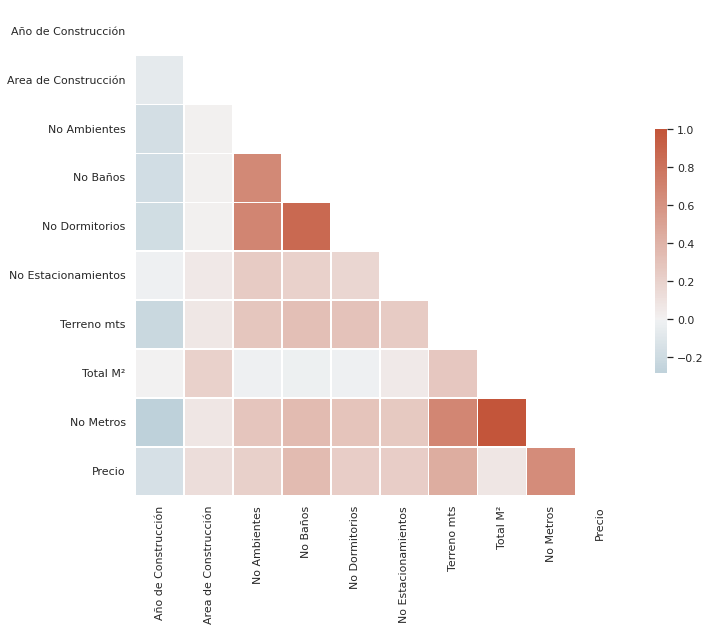

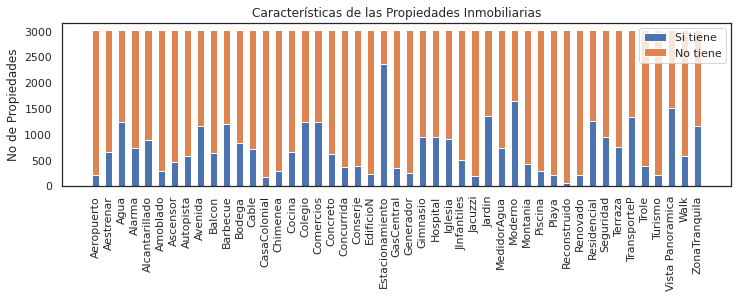

In [ ]:
print('-----------------------------------------------------------------')
print('Cargando datos')
print('-----------------------------------------------------------------')
Limpieza =PrepararDatos(BASE_FOLDER)
continuos, categoricos, ubicacion, binarios= Limpieza.SeparaAtributos(Limpieza.df)
print('-----------------------------------------------------------------')
print('Descripción de los datos Categóricos')
display(categoricos.describe())
print('-----------------------------------------------------------------')
print('Valores del atributo Estado')
print('-----------------------------------------------------------------')
display(categoricos['Estado'].unique())
print('-----------------------------------------------------------------')
print('Valores del atributo Tipo de Propiedad')
print('-----------------------------------------------------------------')
display(categoricos['Tipo Propiedad'].unique())
print('-----------------------------------------------------------------')
estadisticas = pd.DataFrame(continuos.describe())
print('-----------------------------------------------------------------')
print('Atributos Continuos')
print('-----------------------------------------------------------------')
display(estadisticas.transpose())
print('-----------------------------------------------------------------')
print('Correlaciones de Atributos Continuos')
print('-----------------------------------------------------------------')
Limpieza.GraficaCorrelaciones(continuos)
#Limpieza.GraficarHistogramas(continuos)
print('-----------------------------------------------------------------')
print('Atributos Discretos')
print('-----------------------------------------------------------------')
Limpieza.GraficarDiscretos(Limpieza.df)

# Validacion de los datos

-----------------------------------------------------------------
División de los Datos
-----------------------------------------------------------------
Hay 1688 datos de entrenamiento
Hay 724 datos de validación
Hay 603 datos de prueba


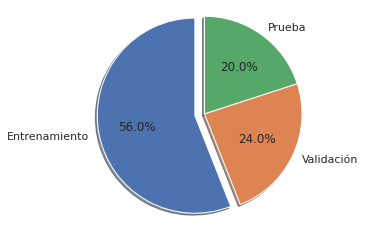

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(Limpieza.df, Limpieza.df, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42)
print('-----------------------------------------------------------------')
print('División de los Datos')
print('-----------------------------------------------------------------')
print('Hay ' + str(x_train.shape[0])+  ' datos de entrenamiento')
print('Hay ' + str(x_val.shape[0])+  ' datos de validación')
print('Hay ' + str(x_test.shape[0])+  ' datos de prueba')
labels = 'Entrenamiento', 'Validación', 'Prueba'
sizes = [x_train.shape[0], x_val.shape[0],x_test.shape[0]]
explode = (0.1, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Imputar los valores ausentes

Consideraciones:
- En aquellas instancias (filas) que contengan dos columnas con valores NaN en alguno de sus atributos (columnas), se imputarán dichos valores.
 * Si el atributo corresponde a una variable discreta, se imputará el valor utilizando la moda de dicho atributo. 
 * Si el atributo corresponde a una variable continua, se imputará el valor utilizando la media de dicho atributo. 
- Aquellas instancias (filas) que contengan MÁS DE dos valors NaN en sus atributos, deberán ser eliminadas por completo. 


In [ ]:
x_train_cont, x_train_cat, x_train_ubi, x_train_bin = Limpieza.SeparaAtributos(x_train)
x_val_cont, x_val_cat, x_val_ubi, x_val_bin  = Limpieza.SeparaAtributos(x_val)
x_test_cont, x_test_cat, x_test_ubi, x_test_bin  = Limpieza.SeparaAtributos(x_test)

print('-----------------------------------------------------------------')
print('Imputación de valores ausentes de los Datos Continuos')
print('-----------------------------------------------------------------')

Limpieza.EntrenarImputadorContinuo(x_train_cont)
x_train_cont_imp = Limpieza.ImputarContinuos(x_train_cont)
x_val_cont_imp = Limpieza.ImputarContinuos(x_val_cont)
x_test_cont_imp = Limpieza.ImputarContinuos(x_test_cont)

print('-----------------------------------------------------------------')
print('Imputación de valores ausentes de los Datos Discretos')
print('-----------------------------------------------------------------')

Limpieza.EntrenarImputadorDiscreto(x_train_cat)
x_train_cat_imp = Limpieza.ImputarDiscretos(x_train_cat)
x_val_cat_imp = Limpieza.ImputarDiscretos(x_val_cat)
x_test_cat_imp = Limpieza.ImputarDiscretos(x_test_cat)

print('----------------------------------------------------------------------------')
print('Forma de los sub conjuntos luego de la Imputación de valores ausentes')
print('----------------------------------------------------------------------------')

print('Datos continuos    : Train[' + str(x_train_cont_imp.shape) + '] + Val[' + str(x_val_cont_imp.shape) + '] + Test[' +   str(x_test_cont_imp.shape)+']') 
print('Datos de ubicación : Train[' + str(x_train_ubi.shape) +']  + Val[' + str(x_val_ubi.shape) + ']  + Test[' +   str(x_test_ubi.shape)+']') 
print('Datos categoricos  : Train[' + str(x_train_cat_imp.shape) + ']  + Val[' + str(x_val_cat_imp.shape) + ']  + Test['+   str(x_test_cat_imp.shape)+']') 
print('Datos binarios     : Train[' + str(x_train_bin.shape) + '] + Val['+ str(x_val_bin.shape) + '] + Test[' +   str(x_test_bin.shape)+']') 

-----------------------------------------------------------------
Imputación de valores ausentes de los Datos Continuos
-----------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Año de Construcción,1688.0,2007.206161,14.999155,1702.0,2001.0,2010.000,2017.0000,2025.0
Area de Construcción,1688.0,406.405990,2930.510714,1.0,106.0,180.000,400.0000,111618.0
No Ambientes,1688.0,6.071090,6.111660,0.0,0.0,6.000,9.0000,71.0
No Baños,1688.0,2.213270,2.428982,0.0,1.0,2.000,3.0000,48.0
No Dormitorios,1688.0,2.895142,2.899261,0.0,2.0,3.000,3.0000,46.0
No Estacionamientos,1688.0,1.276659,2.176531,0.0,0.0,1.000,2.0000,40.0
Terreno mts,1688.0,150.779788,174.804073,0.0,0.0,120.010,186.1350,977.0
Total M²,1688.0,803.562555,6156.637509,30.0,108.0,165.675,309.9025,156000.0
No Metros,1688.0,214.820524,162.448877,0.0,108.0,165.300,252.6625,994.0
Precio,1688.0,181977.551878,242687.443701,16000.0,80875.0,125000.000,200000.0000,5500000.0


,count,mean,std,min,25%,50%,75%,max
Año de Construcción,724.0,2006.750000,13.370544,1920.00,2000.0000,2010.000,2017.00000,2023.0
Area de Construcción,724.0,641.193703,4356.484877,24.00,112.9325,183.220,406.40599,99797.0
No Ambientes,724.0,6.187845,7.366559,0.00,0.0000,6.000,9.00000,135.0
No Baños,724.0,2.295580,4.000129,0.00,1.0000,2.000,3.00000,100.0
No Dormitorios,724.0,3.098066,5.142242,0.00,2.0000,3.000,4.00000,122.0
No Estacionamientos,724.0,1.229282,2.072656,0.00,0.0000,1.000,2.00000,22.0
Terreno mts,724.0,152.713050,177.288914,0.00,0.0000,131.000,200.00000,992.0
Total M²,724.0,1154.415235,13906.073052,14.18,108.0525,171.400,300.00000,350267.0
No Metros,724.0,218.903784,164.424914,14.18,107.8725,171.095,260.50000,950.0
Precio,724.0,181111.811685,194305.218409,29000.00,85000.0000,125050.000,200000.00000,2500000.0


,count,mean,std,min,25%,50%,75%,max
Año de Construcción,603.0,2006.749585,17.838384,1730.00,2001.000,2010.00,2017.00000,2023.0
Area de Construcción,603.0,446.404363,1644.303097,43.00,117.500,192.00,406.40599,21680.0
No Ambientes,603.0,6.421227,6.234484,0.00,0.000,6.00,9.00000,44.0
No Baños,603.0,2.396352,2.281761,0.00,1.000,2.00,3.00000,26.0
No Dormitorios,603.0,2.961857,2.534848,0.00,2.000,3.00,3.00000,24.0
No Estacionamientos,603.0,1.386401,2.292907,0.00,0.000,1.00,2.00000,30.0
Terreno mts,603.0,162.593871,175.415286,0.00,0.000,140.29,204.15000,869.0
Total M²,603.0,2093.235141,37860.199617,45.43,115.525,178.00,310.82500,928000.0
No Metros,603.0,226.836509,166.447549,45.43,115.525,178.00,270.00000,993.0
Precio,603.0,198484.021012,376949.689589,17000.00,87278.000,133300.00,218000.00000,7013204.0


-----------------------------------------------------------------
Imputación de valores ausentes de los Datos Discretos
-----------------------------------------------------------------


,Estado,Dirección,Tipo Propiedad
count,1688,1688,1688
unique,4,1509,2
top,Usada,"MANTA - Sur de Manta - Manta, Ecuador",Casa
freq,1444,14,947


,Estado,Dirección,Tipo Propiedad
count,724,724,724
unique,4,681,2
top,Usada,Mariano Paredes y Tadeo Benitez - Mariano Pare...,Casa
freq,602,5,422


,Estado,Dirección,Tipo Propiedad
count,603,603,603
unique,4,574,2
top,Usada,"MANTA - Sur de Manta - Manta, Ecuador",Casa
freq,507,5,347


----------------------------------------------------------------------------
Forma de los sub conjuntos luego de la Imputación de valores ausentes
----------------------------------------------------------------------------
Datos continuos    : Train[(1688, 10)] + Val[(724, 10)] + Test[(603, 10)]
Datos de ubicación : Train[(1688, 2)]  + Val[(724, 2)]  + Test[(603, 2)]
Datos categoricos  : Train[(1688, 3)]  + Val[(724, 3)]  + Test[(603, 3)]
Datos binarios     : Train[(1688, 47)] + Val[(724, 47)] + Test[(603, 47)]


# Eliminar Outliers

1.b) Eliminación de valores outliers EXTREMOS
vamos a retirar los valores cuya latitud y longitud no esten dentro de ecuador, para ellos vamos identificar los outliers con esos campos

In [ ]:
Limpieza.OutliersUbicacionEntrenar(x_train_ubi)
x_train_ubi_so, x_train_cont_so, x_train_cat_so, x_train_bin_so= Limpieza.OutliersUbicacion(x_train_ubi, x_train_cont_imp, x_train_cat_imp, x_train_bin)
x_val_ubi_so, x_val_cont_so, x_val_cat_so, x_val_bin_so = Limpieza.OutliersUbicacion(x_val_ubi, x_val_cont_imp, x_val_cat_imp, x_val_bin)
x_test_ubi_so, x_test_cont_so, x_test_cat_so, x_test_bin_so = Limpieza.OutliersUbicacion(x_test_ubi, x_test_cont_imp, x_test_cat_imp, x_test_bin)
#Limpieza.locationmap

validos completo : (1648, 10)
outliers : (40, 2)
validos completo : (704, 10)
outliers : (20, 2)
validos completo : (584, 10)
outliers : (19, 2)


In [ ]:
print('---------------------------------------------------------------------------------')
print('Forma de los sub conjuntos luego de retirar los outliers de la latitud y longitud')
print('---------------------------------------------------------------------------------')

print('Datos continuos    : Train[' + str(x_train_cont_so.shape) + '] + Val[' + str(x_val_cont_so.shape) + '] + Test[' +   str(x_test_cont_so.shape)+']') 
print('Datos de ubicación : Train[' + str(x_train_ubi_so.shape) +']  + Val[' + str(x_val_ubi_so.shape) + ']  + Test[' +   str(x_test_ubi_so.shape)+']') 
print('Datos categoricos  : Train[' + str(x_train_cat_so.shape) + ']  + Val[' + str(x_val_cat_so.shape) + ']  + Test['+   str(x_test_cat_so.shape)+']') 
print('Datos binarios     : Train[' + str(x_train_bin_so.shape) + '] + Val['+ str(x_val_bin_so.shape) + '] + Test[' +   str(x_test_bin_so.shape)+']') 


---------------------------------------------------------------------------------
Forma de los sub conjuntos luego de retirar los outliers de la latitud y longitud
---------------------------------------------------------------------------------
Datos continuos    : Train[(1648, 10)] + Val[(704, 10)] + Test[(584, 10)]
Datos de ubicación : Train[(1648, 2)]  + Val[(704, 2)]  + Test[(584, 2)]
Datos categoricos  : Train[(1648, 3)]  + Val[(704, 3)]  + Test[(584, 3)]
Datos binarios     : Train[(1648, 47)] + Val[(704, 47)] + Test[(584, 47)]


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-15.188638921045623 > -15.282067199985441). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.654779746974281 > -13.097275617564051). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.011686229788687 > -12.288628503207693). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/p

validos completo : (1622, 10)
outliers : (26, 10)
validos completo : (694, 10)
outliers : (10, 10)
validos completo : (576, 10)
outliers : (8, 10)


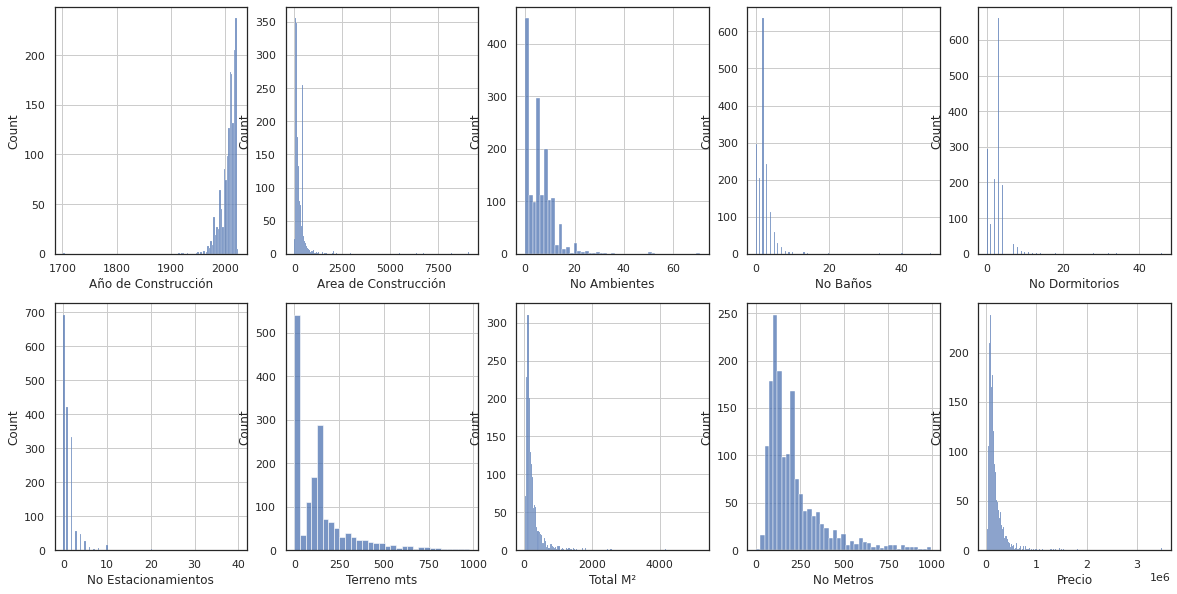

In [ ]:
Limpieza.OutliersContinuosEntrenar(x_train_cont_so, 2, 98)
x_train_cont_so1, x_train_cat_imp1, x_train_bin1, x_train_ubi1 = Limpieza.OutliersContinuos(x_train_cont_so, x_train_cat_so, x_train_bin_so, x_train_ubi_so)
x_val_cont_so1, x_val_cat_imp1, x_val_bin1, x_val_ubi1 = Limpieza.OutliersContinuos(x_val_cont_so, x_val_cat_so, x_val_bin_so, x_val_ubi_so)
x_test_cont_so1, x_test_cat_imp1, x_test_bin1, x_test_ubi1 = Limpieza.OutliersContinuos(x_test_cont_so, x_test_cat_so, x_test_bin_so, x_test_ubi_so)
Limpieza.GraficarHistogramas(x_train_cont_so1)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-16.118037145854583 > -16.956971571835130). You may want to try with a higher value of support_fraction (current value: 0.504).
  RuntimeWarning,


validos completo : (1586, 10)
outliers : (62, 10)
validos completo : (682, 10)
outliers : (22, 10)
validos completo : (562, 10)
outliers : (22, 10)


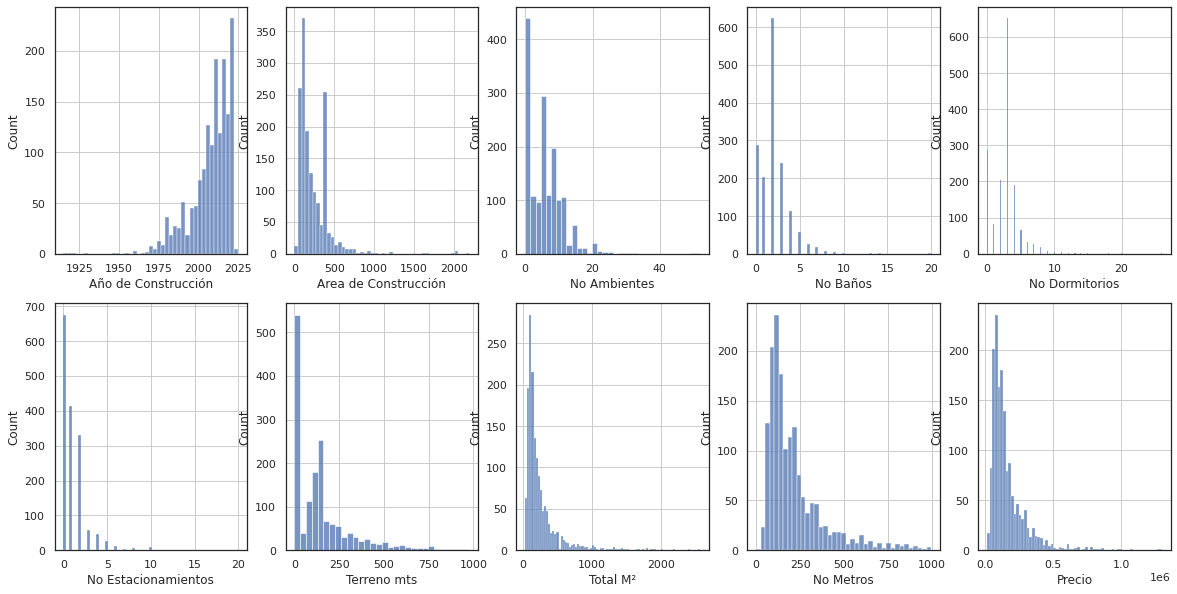

In [ ]:
Limpieza.OutliersContinuosEntrenar(x_train_cont_so, 5, 95)
x_train_cont_so1, x_train_cat_imp1, x_train_bin1, x_train_ubi1 = Limpieza.OutliersContinuos(x_train_cont_so, x_train_cat_so, x_train_bin_so, x_train_ubi_so)
x_val_cont_so1, x_val_cat_imp1, x_val_bin1, x_val_ubi1 = Limpieza.OutliersContinuos(x_val_cont_so, x_val_cat_so, x_val_bin_so, x_val_ubi_so)
x_test_cont_so1, x_test_cat_imp1, x_test_bin1, x_test_ubi1 = Limpieza.OutliersContinuos(x_test_cont_so, x_test_cat_so, x_test_bin_so, x_test_ubi_so)
Limpieza.GraficarHistogramas(x_train_cont_so1)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-14.192363669964774 > -15.788602876301873). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-15.922163798845656 > -16.482793628342375). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-13.505043934757804 > -14.519557297093392). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/p

validos completo : (1573, 10)
outliers : (75, 10)
validos completo : (672, 10)
outliers : (32, 10)
validos completo : (559, 10)
outliers : (25, 10)


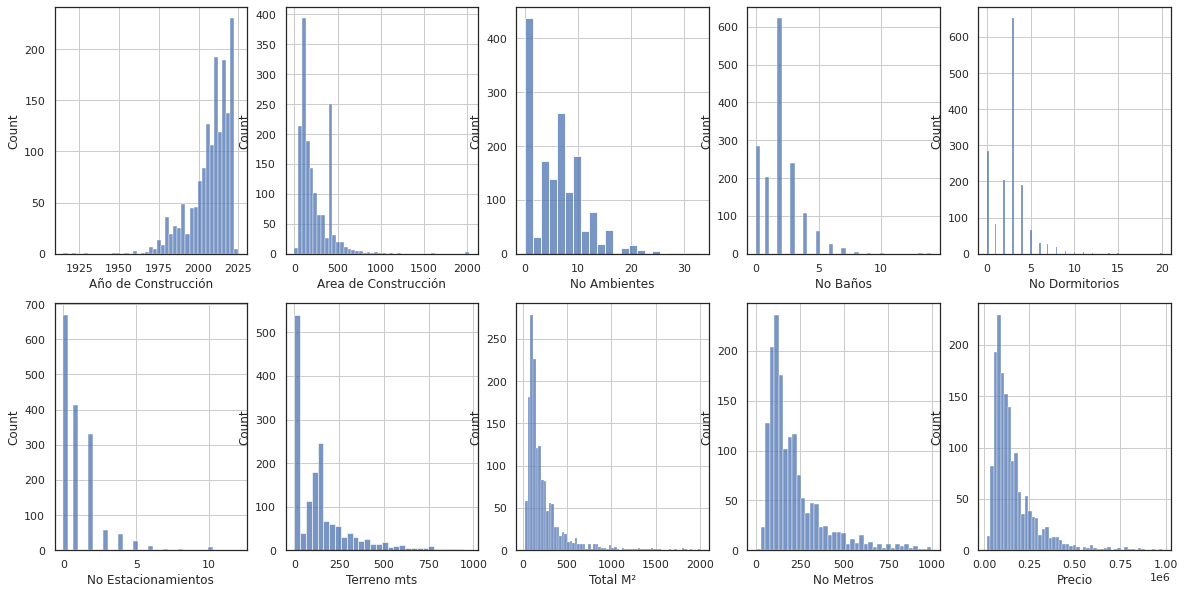

In [ ]:
Limpieza.OutliersContinuosEntrenar(x_train_cont_so, 10, 90)
x_train_cont_so1, x_train_cat_imp1, x_train_bin1, x_train_ubi1 = Limpieza.OutliersContinuos(x_train_cont_so, x_train_cat_so, x_train_bin_so, x_train_ubi_so)
x_val_cont_so1, x_val_cat_imp1, x_val_bin1, x_val_ubi1 = Limpieza.OutliersContinuos(x_val_cont_so, x_val_cat_so, x_val_bin_so, x_val_ubi_so)
x_test_cont_so1, x_test_cat_imp1, x_test_bin1, x_test_ubi1 = Limpieza.OutliersContinuos(x_test_cont_so, x_test_cat_so, x_test_bin_so, x_test_ubi_so)
Limpieza.GraficarHistogramas(x_train_cont_so1)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-8.595637524924125 > -14.097449462911698). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-13.275057340343427 > -13.998600689231470). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-14.263136127157008 > -14.408889094350148). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/py

validos completo : (1559, 10)
outliers : (89, 10)
validos completo : (665, 10)
outliers : (39, 10)
validos completo : (551, 10)
outliers : (33, 10)


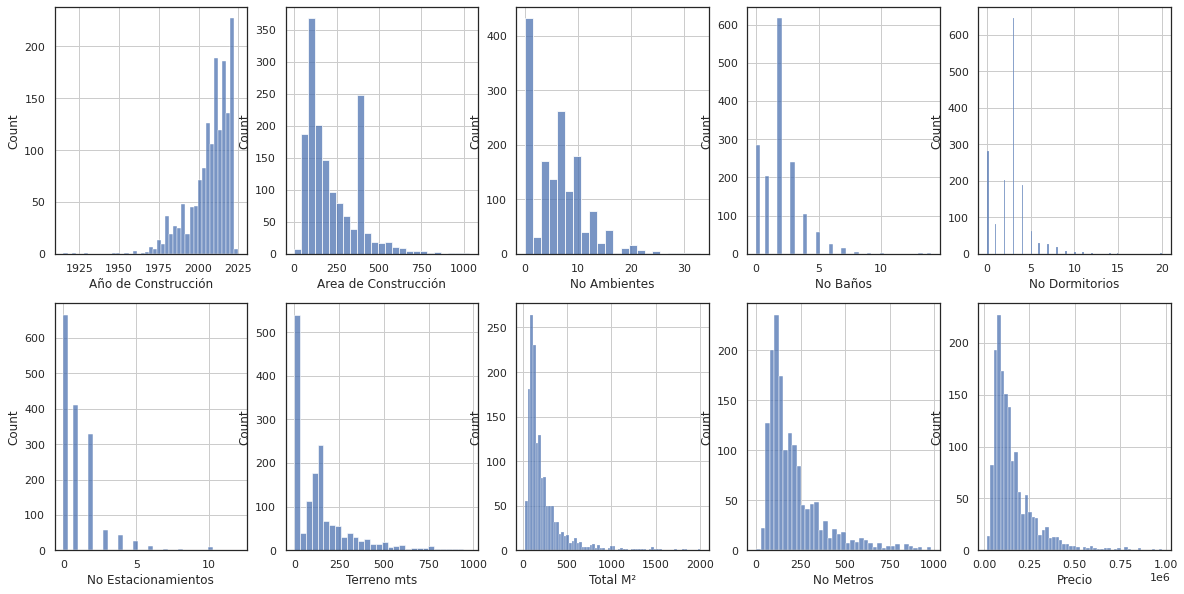

In [ ]:
Limpieza.OutliersContinuosEntrenar(x_train_cont_so, 15, 85)
x_train_cont_so1, x_train_cat_imp1, x_train_bin1, x_train_ubi1 = Limpieza.OutliersContinuos(x_train_cont_so, x_train_cat_so, x_train_bin_so, x_train_ubi_so)
x_val_cont_so1, x_val_cat_imp1, x_val_bin1, x_val_ubi1 = Limpieza.OutliersContinuos(x_val_cont_so, x_val_cat_so, x_val_bin_so, x_val_ubi_so)
x_test_cont_so1, x_test_cat_imp1, x_test_bin1, x_test_ubi1 = Limpieza.OutliersContinuos(x_test_cont_so, x_test_cat_so, x_test_bin_so, x_test_ubi_so)
Limpieza.GraficarHistogramas(x_train_cont_so1)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-13.649418751732778 > -14.105238142585236). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-12.557063040890529 > -13.632022542073017). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-14.998244784289419 > -15.749163162572383). You may want to try with a higher value of support_fraction (current value: 0.504).
  RuntimeWarning,


validos completo : (1460, 10)
outliers : (188, 10)
validos completo : (626, 10)
outliers : (78, 10)
validos completo : (532, 10)
outliers : (52, 10)


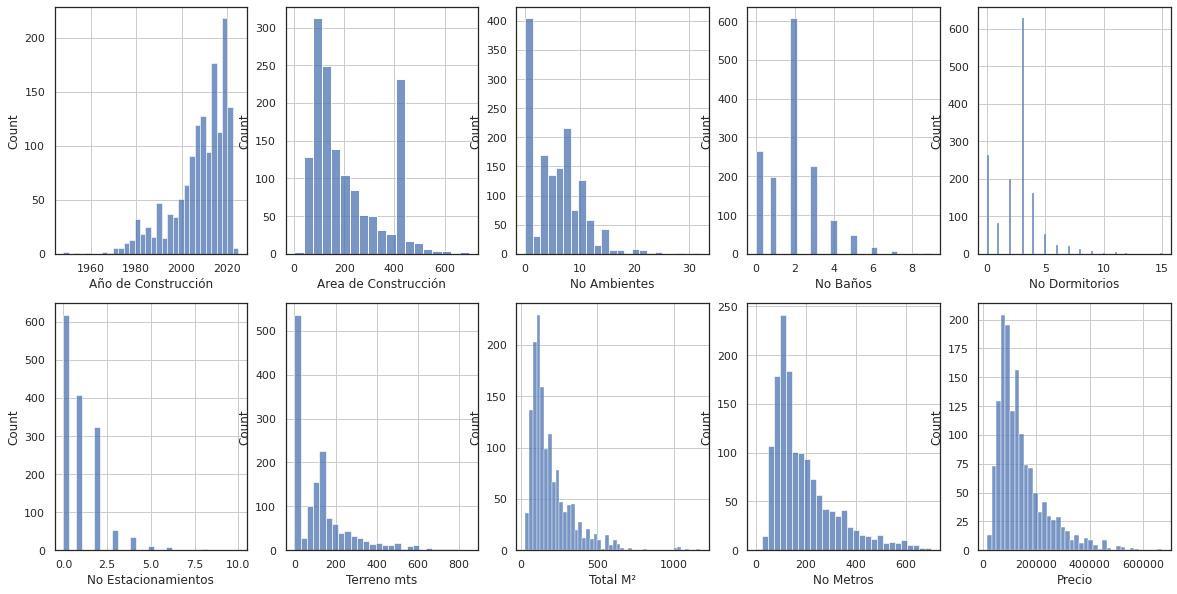

In [ ]:
Limpieza.OutliersContinuosEntrenar(x_train_cont_so, 20, 80)
x_train_cont_so1, x_train_cat_imp1, x_train_bin1, x_train_ubi1 = Limpieza.OutliersContinuos(x_train_cont_so, x_train_cat_so, x_train_bin_so, x_train_ubi_so)
x_val_cont_so1, x_val_cat_imp1, x_val_bin1, x_val_ubi1 = Limpieza.OutliersContinuos(x_val_cont_so, x_val_cat_so, x_val_bin_so, x_val_ubi_so)
x_test_cont_so1, x_test_cat_imp1, x_test_bin1, x_test_ubi1 = Limpieza.OutliersContinuos(x_test_cont_so, x_test_cat_so, x_test_bin_so, x_test_ubi_so)
Limpieza.GraficarHistogramas(x_train_cont_so1)

In [ ]:
print('---------------------------------------------------------------------------------')
print('Forma de los sub conjuntos luego de retirar todos los outliers umbral[15-85]')
print('---------------------------------------------------------------------------------')

print('Datos continuos    : Train[' + str(x_train_cont_so1.shape) + '] + Val[' + str(x_val_cont_so1.shape) + '] + Test[' +   str(x_test_cont_so1.shape)+']') 
print('Datos de ubicación : Train[' + str(x_train_ubi1.shape) +']  + Val[' + str(x_val_ubi1.shape) + ']  + Test[' +   str(x_test_ubi1.shape)+']') 
print('Datos categoricos  : Train[' + str(x_train_cat_imp1.shape) + ']  + Val[' + str(x_val_cat_imp1.shape) + ']  + Test['+   str(x_test_cat_imp1.shape)+']') 
print('Datos binarios     : Train[' + str(x_train_bin1.shape) + '] + Val['+ str(x_val_bin1.shape) + '] + Test[' +   str(x_test_bin1.shape)+']') 

---------------------------------------------------------------------------------
Forma de los sub conjuntos luego de retirar todos los outliers umbral[15-85]
---------------------------------------------------------------------------------
Datos continuos    : Train[(1460, 10)] + Val[(626, 10)] + Test[(532, 10)]
Datos de ubicación : Train[(1460, 2)]  + Val[(626, 2)]  + Test[(532, 2)]
Datos categoricos  : Train[(1460, 3)]  + Val[(626, 3)]  + Test[(532, 3)]
Datos binarios     : Train[(1460, 47)] + Val[(626, 47)] + Test[(532, 47)]


# Crear el atributo Grupo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

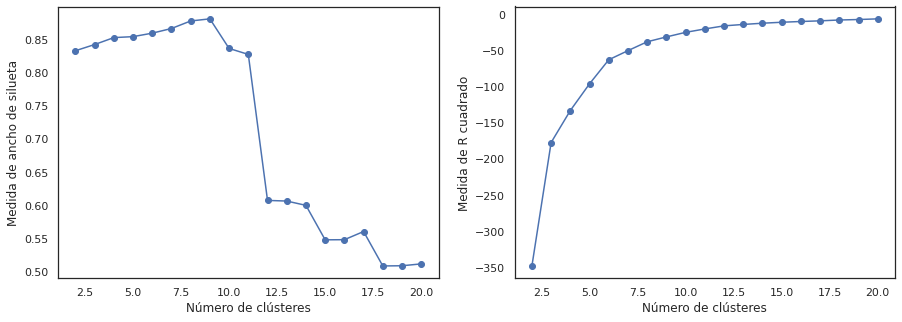

In [ ]:
Limpieza.CrearGrupoEntrenar(x_train_ubi1)
Limpieza.CrearGrupo(x_train_ubi1)
Limpieza.CrearGrupo(x_val_ubi1)
Limpieza.CrearGrupo(x_test_ubi1)

df_train_comp= x_train_cont_so1
df_train_comp.index = range(df_train_comp.shape[0])
# agregamos a los continuos los atributos de ubicacion
x_train_ubi1.index = range(x_train_ubi1.shape[0])
df_train_comp = pd.concat([df_train_comp, x_train_ubi1.iloc[:,0:2]], axis=1,)
# agregamos a los categoricos el nuevo campo de grupo
x_train_cat_imp1.index = range(x_train_cat_imp1.shape[0])
x_train_cat_imp1 = pd.concat([x_train_cat_imp1, x_train_ubi1.iloc[:,2]], axis=1,)

df_val_comp= x_val_cont_so1
df_val_comp.index = range(df_val_comp.shape[0])
x_val_ubi1.index = range(x_val_ubi1.shape[0])
df_val_comp = pd.concat([df_val_comp, x_val_ubi1.iloc[:,0:2]], axis=1,)
# agregamos a los categoricos el nuevo campo de grupo
x_val_cat_imp1.index = range(x_val_cat_imp1.shape[0])
x_val_cat_imp1 = pd.concat([x_val_cat_imp1, x_val_ubi1.iloc[:,2]], axis=1,)

df_test_comp= x_test_cont_so1
df_test_comp.index = range(df_test_comp.shape[0])
x_test_ubi1.index = range(x_test_ubi1.shape[0])
df_test_comp = pd.concat([df_test_comp, x_test_ubi1.iloc[:,0:2]], axis=1,)
# agregamos a los categoricos el nuevo campo de grupo
x_test_cat_imp1.index = range(x_test_cat_imp1.shape[0])
x_test_cat_imp1 = pd.concat([x_test_cat_imp1, x_test_ubi1.iloc[:,2]], axis=1,)

df_limpios_train = pd.concat([df_train_comp, x_train_cat_imp1], axis=1,)
df_limpios_val = pd.concat([df_val_comp, x_val_cat_imp1], axis=1,)
df_limpios_test = pd.concat([df_test_comp, x_test_cat_imp1], axis=1,)
#Limpieza.GraficarUbicacionGrupo(df_limpios)

# guardar los datos limpios
df_limpios_train.to_csv(BASE_FOLDER+"df_limpios_train.csv", index=False)
df_limpios_val.to_csv(BASE_FOLDER+"df_limpios_val.csv", index=False)
df_limpios_test.to_csv(BASE_FOLDER+"df_limpios_test.csv", index=False)


In [ ]:
#Limpieza.locationmap

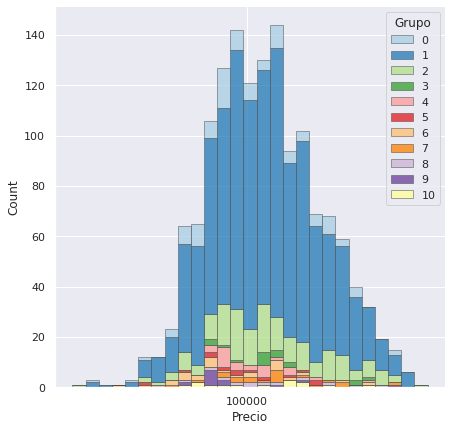

In [ ]:
import matplotlib as mpl
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(7, 7))
sns.despine(f)

sns.histplot(
    df_limpios_train,
    x="Precio", hue="Grupo",
    multiple="stack",
    palette="Paired",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


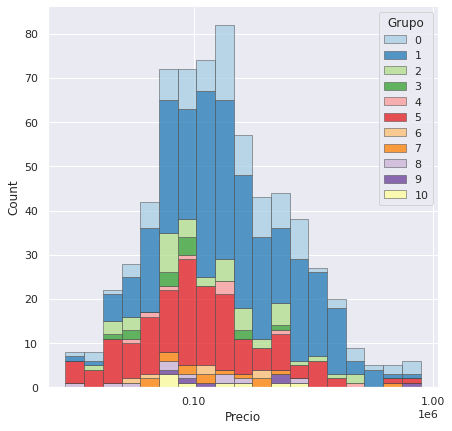

In [ ]:
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(7, 7))
sns.despine(f)

sns.histplot(
    df_limpios_val,
    x="Precio", hue="Grupo",
    multiple="stack",
    palette="Paired",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

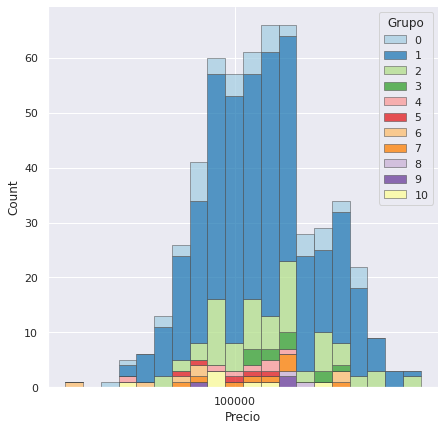

In [ ]:
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(7, 7))
sns.despine(f)

sns.histplot(
    df_limpios_test,
    x="Precio", hue="Grupo",
    multiple="stack",
    palette="Paired",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

Nomalizar los datos

In [ ]:
#obtener las etiquetas
y_train = pd.DataFrame(df_train_comp.iloc[:, 9:10])
y_val = pd.DataFrame(df_val_comp.iloc[:, 9:10])
y_test = pd.DataFrame(df_test_comp.iloc[:, 9:10])

In [ ]:
df_train_comp.shape

(1460, 12)

In [ ]:
y_test.shape

(531, 1)

In [ ]:
y_train.to_csv(BASE_FOLDER+"df_y_train.csv", index=False)
y_val.to_csv(BASE_FOLDER+"df_y_val.csv", index=False)
y_test.to_csv(BASE_FOLDER+"df_y_test.csv", index=False)


In [ ]:
Limpieza.EntrenarNormalizar(df_train_comp)
x_train_cont_no= Limpieza.Normalizar(df_train_comp)
x_val_cont_no= Limpieza.Normalizar(df_val_comp)
x_test_cont_no= Limpieza.Normalizar(df_test_comp)


OnehotEncode

In [ ]:
Limpieza.EntrenarGestionCategoricos(x_train_cat_imp1)
x_train_Estado, x_train_tipo, x_train_grupo =Limpieza.GestionCategoricos(x_train_cat_imp1)
x_val_Estado, x_val_tipo, x_val_grupo =Limpieza.GestionCategoricos(x_val_cat_imp1)
x_test_Estado, x_test_tipo, x_test_grupo =Limpieza.GestionCategoricos(x_test_cat_imp1)

In [ ]:
def  GraficaDistribucion(df_train, df_val, df_test):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
  # Train
  labels = df_train.columns
  sizes = df_train.sum()
  colors = sns.color_palette('pastel')[0:5]
  #explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0.1, 0, 0)  
  ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', colors = colors, shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax1.set_xlabel("Train")

  # Center the data to make it diverging
  y2 = df_val.sum()
  ax2.pie(y2,  labels=labels, autopct='%1.1f%%', colors = colors, shadow=True, startangle=90)
  ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax2.set_xlabel("Val")

  y3 = df_test.sum()
  ax3.pie(y3,  labels=labels, autopct='%1.1f%%', colors = colors, shadow=True, startangle=90)
  ax3.axis('equal')
  ax3.set_xlabel("Test")


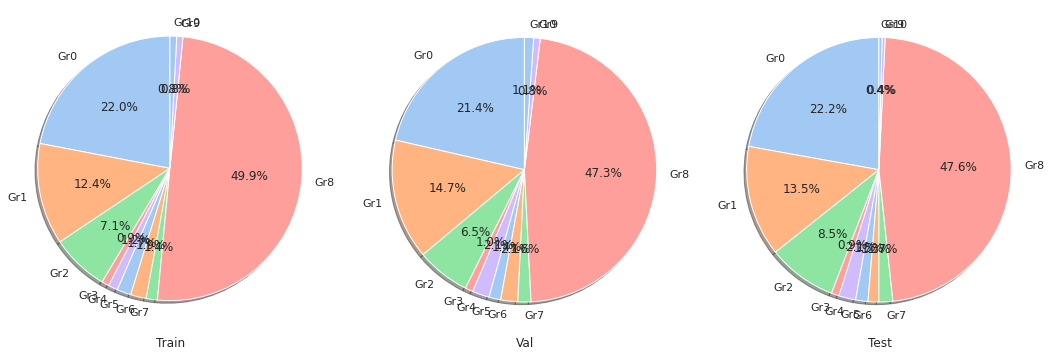

In [ ]:
GraficaDistribucion(x_train_grupo, x_val_grupo, x_test_grupo)

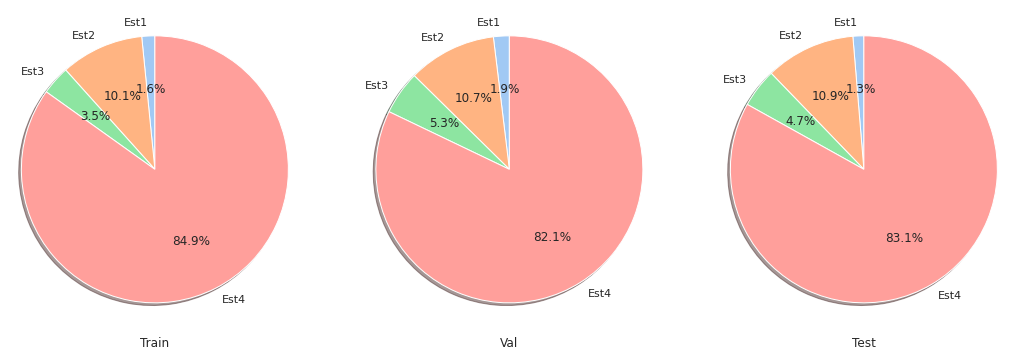

In [ ]:
GraficaDistribucion(x_train_Estado, x_val_Estado, x_test_Estado)

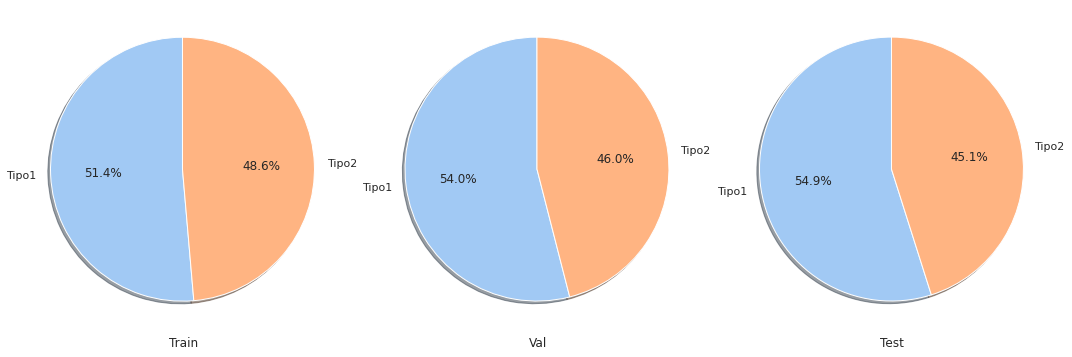

In [ ]:
GraficaDistribucion(x_train_tipo, x_val_tipo, x_test_tipo)

In [ ]:
x_train_Estado.index = range(x_train_Estado.shape[0])
df_train_final = pd.concat([x_train_cont_no, x_train_Estado], axis=1,)
x_train_tipo.index = range(x_train_tipo.shape[0])
df_train_final = pd.concat([df_train_final, x_train_tipo], axis=1,)
x_train_grupo.index = range(x_train_grupo.shape[0])
df_train_final = pd.concat([df_train_final, x_train_grupo], axis=1,)
x_train_bin1.index = range(x_train_bin1.shape[0])
df_train_final = pd.concat([df_train_final, x_train_bin1], axis=1,)

x_val_Estado.index = range(x_val_Estado.shape[0])
df_val_final = pd.concat([x_val_cont_no, x_val_Estado], axis=1,)
x_val_tipo.index = range(x_val_tipo.shape[0])
df_val_final = pd.concat([df_val_final, x_val_tipo], axis=1,)
x_val_grupo.index = range(x_val_grupo.shape[0])
df_val_final = pd.concat([df_val_final, x_val_grupo], axis=1,)
x_val_bin1.index = range(x_val_bin1.shape[0])
df_val_final = pd.concat([df_val_final, x_val_bin1], axis=1,)

x_test_Estado.index = range(x_test_Estado.shape[0])
df_test_final = pd.concat([x_test_cont_no, x_test_Estado], axis=1,)
x_test_tipo.index = range(x_test_tipo.shape[0])
df_test_final = pd.concat([df_test_final, x_test_tipo], axis=1,)
x_test_grupo.index = range(x_test_grupo.shape[0])
df_test_final = pd.concat([df_test_final, x_test_grupo], axis=1,)
x_test_bin1.index = range(x_test_bin1.shape[0])
df_test_final = pd.concat([df_test_final, x_test_bin1], axis=1,)

df_train_final.to_csv(BASE_FOLDER+"df_train_final.csv", index=False)
df_val_final.to_csv(BASE_FOLDER+"df_val_final.csv", index=False)
df_test_final.to_csv(BASE_FOLDER+"df_test_final.csv", index=False)

df_test_final

,Año de Construcción,Area de Construcción,No Ambientes,No Baños,No Dormitorios,No Estacionamientos,Terreno mts,Total M²,No Metros,Precio,...,Renovado,Residencial,Seguridad,Terraza,TransporteP,Trole,Turismo,Vista Panoramica,Walk,ZonaTranquila
0,0.415584,0.394226,0.21875,0.333333,0.333333,0.1,0.352941,0.215979,0.393723,0.214067,...,0,1,0,1,1,0,0,1,0,1
1,0.441558,0.237969,0.18750,0.222222,0.200000,0.1,0.196471,0.120281,0.238231,0.220183,...,0,1,0,0,1,0,0,0,0,1
2,0.909091,0.165102,0.18750,0.222222,0.200000,0.0,0.177388,0.075654,0.165720,0.099388,...,0,1,0,0,1,0,0,1,0,0
3,0.883117,0.188440,0.43750,0.333333,0.200000,0.1,0.155824,0.089947,0.188944,0.219419,...,0,1,1,0,1,0,0,0,1,1
4,0.857143,0.328282,0.12500,0.444444,0.200000,0.2,0.000000,0.337138,0.590585,0.449541,...,0,1,1,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0.402597,1.186978,0.62500,0.444444,0.333333,0.3,0.628235,0.701493,1.182596,0.663609,...,0,1,1,1,1,1,0,0,0,1
528,0.766234,0.174893,0.00000,0.222222,0.200000,0.0,0.177388,0.132572,0.258203,0.136086,...,0,1,1,0,1,0,1,1,0,1
529,0.779221,0.313947,0.25000,0.222222,0.200000,0.2,0.156471,0.166813,0.313837,0.249235,...,0,0,0,0,0,0,0,1,0,0
530,0.922078,0.342618,0.00000,0.000000,0.000000,0.6,0.155294,0.219491,0.399429,0.107034,...,0,1,0,1,1,0,0,0,0,1


Ya tenemos los datos listos, ahora hay que modelar